In [1]:
from google.colab import files
import os

print("Upload your kaggle.json (dans ~/.kaggle/kaggle.json)")
files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
os.replace('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

Upload your kaggle.json (dans ~/.kaggle/kaggle.json)


Saving kaggle.json to kaggle.json


## Téléchargement et préparation du dataset Market-1501

In [2]:
!kaggle datasets download -d pengcw1/market-1501 -p data

data_path = 'data/Market-1501-v15.09.15'

dest = data_path
import shutil
if os.path.isdir(dest): shutil.rmtree(dest)
!unzip -q data/market-1501.zip -d data

for sub in ['bounding_box_train','bounding_box_test','query']:
    assert os.path.isdir(os.path.join(data_path, sub)), f"Missing folder {sub} in {data_path}"
print(f"Dataset prêt dans : {data_path}")

Dataset URL: https://www.kaggle.com/datasets/pengcw1/market-1501
License(s): unknown
market-1501.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset prêt dans : data/Market-1501-v15.09.15


In [4]:
!pip install torch torchvision torchaudio torchreid faiss-cpu matplotlib kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 19.0 MB/s eta 0:00:00
  C

## Entraînement d'un ResNet50 pour Person Re-ID sur Market-1501


In [3]:
# Option 2 : Fine-tuning avec ID Classification

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Préparation des chemins et transformations


In [4]:
data_path = 'data/Market-1501-v15.09.15'
train_dir = os.path.join(data_path, 'bounding_box_train')

# Taille réduite pour alléger la mémoire
transform = transforms.Compose([
    transforms.Resize((128,64)),   # moitié de la taille
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


## 2. Dataset avec ID


In [5]:
def get_pid(fname):
    return int(fname.split('_')[0])

class ReIDDataset(Dataset):
    def __init__(self, folder, transform):
        files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        self.paths = [os.path.join(folder, f) for f in files]
        self.transform = transform
        pids = {get_pid(f) for f in files}
        self.pid_to_label = {pid: i for i, pid in enumerate(sorted(pids))}
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        path = self.paths[idx]
        pid = get_pid(os.path.basename(path))
        label = self.pid_to_label[pid]
        img = Image.open(path).convert('RGB')
        return self.transform(img), label

## 3. DataLoader


In [6]:
batch_size = 32
train_ds = ReIDDataset(train_dir, transform)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)
num_classes = len(train_ds.pid_to_label)

## 4. Modèle


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

## 5. Entraînement


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
losses = []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        try:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(loss=loss.item())
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print('OOM, passage du batch_size à moitié et clear cache')
                torch.cuda.empty_cache()
                batch_size = max(8, batch_size // 2)
                train_loader.batch_size = batch_size
                continue
            else:
                raise e
    avg_loss = running_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch} avg loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 405/405 [00:32<00:00, 12.61it/s, loss=3.76]


Epoch 1 avg loss: 5.0334


Epoch 2/10: 100%|██████████| 405/405 [00:29<00:00, 13.75it/s, loss=2.34]


Epoch 2 avg loss: 1.8977


Epoch 3/10: 100%|██████████| 405/405 [00:31<00:00, 13.04it/s, loss=1.74]


Epoch 3 avg loss: 0.5967


Epoch 4/10: 100%|██████████| 405/405 [00:30<00:00, 13.29it/s, loss=0.392]


Epoch 4 avg loss: 0.1693


Epoch 5/10: 100%|██████████| 405/405 [00:30<00:00, 13.25it/s, loss=0.281]


Epoch 5 avg loss: 0.0564


Epoch 6/10: 100%|██████████| 405/405 [00:30<00:00, 13.14it/s, loss=0.118]


Epoch 6 avg loss: 0.0259


Epoch 7/10: 100%|██████████| 405/405 [00:30<00:00, 13.13it/s, loss=0.135]


Epoch 7 avg loss: 0.0250


Epoch 8/10: 100%|██████████| 405/405 [00:31<00:00, 12.95it/s, loss=1.04]


Epoch 8 avg loss: 0.1352


Epoch 9/10: 100%|██████████| 405/405 [00:31<00:00, 13.04it/s, loss=0.776]


Epoch 9 avg loss: 0.1451


Epoch 10/10: 100%|██████████| 405/405 [00:31<00:00, 12.78it/s, loss=0.0793]

Epoch 10 avg loss: 0.0465


## 6. Sauvegarde du backbone


In [13]:
model.eval()
backbone = nn.Sequential(*list(model.children())[:-1])
torch.save(backbone.state_dict(), "resnet50_market1501_backbone.pth")
print("\nBackbone sauvegardé !")


Backbone sauvegardé !


## 7. Affichage de la perte


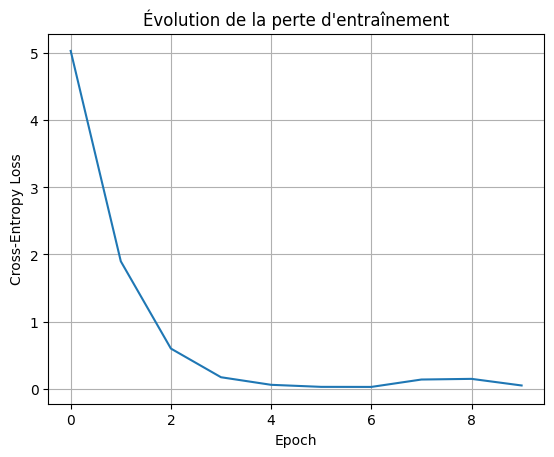

In [14]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Évolution de la perte d'entraînement")
plt.grid(True)
plt.show()

## 8. Évaluation sur query vs gallery

In [15]:
# Recharger le backbone entrainé
backbone = nn.Sequential(*list(resnet.children())[:-1]).to(device)
backbone.eval()

# Fonctions pour extraction et metrics
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

def extract_features(folder, transform, backbone):
    paths = [os.path.join(folder,f) for f in os.listdir(folder) if f.endswith('.jpg')]
    feats, names = [], []
    loader = DataLoader(paths, batch_size=32, shuffle=False)
    for batch in loader:
        imgs = torch.stack([transform(Image.open(p).convert('RGB')) for p in batch]).to(device)
        with torch.no_grad():
            f = backbone(imgs).squeeze(-1).squeeze(-1)  # [B,2048]
        feats.append(f.cpu())
        names.extend(batch)
    return torch.cat(feats), names

# Création des transforms d'évaluation identiques
eval_transform = transforms.Compose([
    transforms.Resize((128,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

query_feats, q_names = extract_features(os.path.join(data_path,'query'), eval_transform, backbone)
gallery_feats, g_names = extract_features(os.path.join(data_path,'bounding_box_test'), eval_transform, backbone)

# Calcul pairwise cosine distance par batch pour éviter OOM
def pairwise_cosine(q, g):
    dist = []
    for qi in q:
        d = 1 - F.cosine_similarity(qi.unsqueeze(0), g)
        dist.append(d)
    return torch.stack(dist)

dist = pairwise_cosine(query_feats, gallery_feats)

# Calcul des métriques Rank-1 et mAP
import numpy as np

def get_id(fname): return int(os.path.basename(fname).split('_')[0])

def get_cam(fname): return int(os.path.basename(fname).split('_')[1][1])

q_ids = [get_id(n) for n in q_names]
q_cams = [get_cam(n) for n in q_names]
g_ids = [get_id(n) for n in g_names]
g_cams = [get_cam(n) for n in g_names]

correct_1=0
APs=[]
for i,(qid,qcam) in enumerate(zip(q_ids,q_cams)):
    dists = dist[i]
    idxs = torch.argsort(dists)
    # filtrage
    valid = [j for j in idxs if g_ids[j]!=-1 and not (g_ids[j]==qid and g_cams[j]==qcam)]
    sorted_ids=[g_ids[j] for j in valid]
    # Rank-1
    if sorted_ids and sorted_ids[0]==qid:
        correct_1+=1
    # mAP
    good=[j for j, pid in enumerate(sorted_ids) if pid==qid]
    if good:
        ap=0
        for rank, pos in enumerate(good): ap+= (rank+1)/(pos+1)
        APs.append(ap/len(good))
    else:
        APs.append(0)

rank1 = correct_1/len(q_ids)*100
map_score = np.mean(APs)*100
print(f"Final Rank-1: {rank1:.2f}%")
print(f"Final mAP: {map_score:.2f}%")

Final Rank-1: 63.93%
Final mAP: 41.01%


## 9. Visualisation des résultats

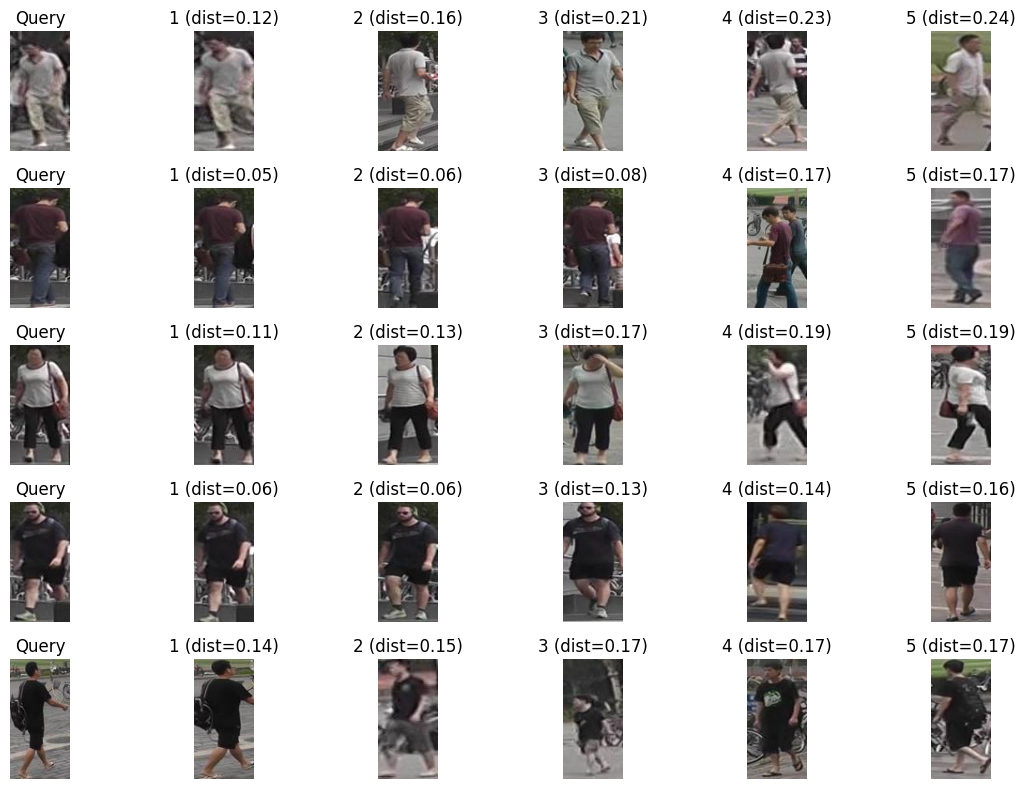

In [19]:
# Afficher pour 5 requêtes aléatoires la query et ses top-5 matches
import random
plt.figure(figsize=(12, 8))
random.seed(42)
indices = random.sample(range(len(q_names)), 5)
for idx, i in enumerate(indices):
    d = dist[i].cpu().numpy()
    top5 = np.argsort(d)[:5]
    # Affichage
    # 1ère colonne = query
    plt.subplot(5, 6, idx*6 + 1)
    qimg = Image.open(q_names[i]).convert('RGB')  # q_names contient déjà le chemin complet
    plt.imshow(qimg.resize((64,128)))
    plt.title('Query')
    plt.axis('off')
    # Colonnes suivantes = top-5 matches
    for j, gid in enumerate(top5):
        plt.subplot(5, 6, idx*6 + 2 + j)
        gimg = Image.open(g_names[gid]).convert('RGB')  # g_names contient le chemin complet
        plt.imshow(gimg.resize((64,128)))
        plt.title(f'{j+1} (dist={d[gid]:.2f})')
        plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()